In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv("ecom-elasticity-data1.tsv", sep="\t")

# Show the first few rows of the data
data.head()


,D9775,Diapers,2017-01-01,12.46,94
0,D80,Diapers,2017-01-01,11.56,102
1,D3248,Diapers,2017-01-01,12.21,93
2,D1714,Diapers,2017-01-01,11.54,75
3,D1408,Diapers,2017-01-01,13.16,94
4,D4564,Diapers,2017-01-01,13.09,86


The dataset seems to have 5 columns, but it looks like the column names are not set correctly. The first row of the dataset appears to be used as column names. Let's correct this and recheck the data. The columns should likely be "ASIN", "Category", "Date", "Price", and "Units Sold".


In [4]:
# Correct the column names and load the data again
data.columns = ["ASIN", "Category", "Date", "Price", "Units Sold"]

# Show the first few rows of the data
data.head()


,ASIN,Category,Date,Price,Units Sold
0,D80,Diapers,2017-01-01,11.56,102
1,D3248,Diapers,2017-01-01,12.21,93
2,D1714,Diapers,2017-01-01,11.54,75
3,D1408,Diapers,2017-01-01,13.16,94
4,D4564,Diapers,2017-01-01,13.09,86


The columns have been correctly set now. The dataset includes the following information:

- ASIN: The unique identifier for each product.
- Category: The category of the product. It seems like we have products from three categories: Diapers, Headphones, and Breakfast Cereals.
- Date: The date when the sales data was recorded.
- Price: The price of the product on the given date.
- Units Sold: The number of units sold on the given date.


Now, let's conduct an exploratory data analysis to get a feel for the data, including checking for missing values, understanding the distribution of data across categories, and reviewing summary statistics. This will allow us to approach the questions you've asked with a better understanding of the data.

In [5]:
# Check for missing values
missing_values = data.isnull().sum()

# Check the distribution of data across categories
category_distribution = data['Category'].value_counts()

# Review summary statistics
summary_stats = data.describe(include='all')

missing_values, category_distribution, summary_stats


(ASIN          0
 Category      0
 Date          0
 Price         0
 Units Sold    0
 dtype: int64,
 Cereals       220000
 Headphones    132000
 Diapers       109999
 Name: Category, dtype: int64,
           ASIN Category        Date          Price     Units Sold
 count   461999   461999      461999  461999.000000  461999.000000
 unique     420        3        1100            NaN            NaN
 top        D80  Cereals  2018-07-05            NaN            NaN
 freq      1100   220000         420            NaN            NaN
 mean       NaN      NaN         NaN      27.144958      20.110141
 std        NaN      NaN         NaN      29.783308      22.913053
 min        NaN      NaN         NaN       2.330000       0.000000
 25%        NaN      NaN         NaN       8.800000       7.000000
 50%        NaN      NaN         NaN       9.780000      11.000000
 75%        NaN      NaN         NaN      55.400000      24.000000
 max        NaN      NaN         NaN     159.530000     595.000000

Here are the initial findings from the dataset:

- There are no missing values in any of the columns, which is great as it means we won't need to handle missing data.
- The dataset contains 461,999 records.
- There are three categories of products: Diapers, Headphones, and Cereals. The Cereals category has the highest number of records (220,000), followed by Headphones (132,000), and Diapers (109,999).
- There are 420 unique ASINs (products) in the dataset.
- The Price ranges from 2.33 to 159.53 with a mean of 27.14. The standard deviation is quite high (29.78), indicating a wide spread of prices.
- The number of Units Sold ranges from 0 to 595 with a mean of 20.11. The standard deviation is also high (22.91), suggesting a significant variability in the number of units sold.
With this understanding of the data, let's move on to the questions outlined in the case study.

Firstly, to identify sale events and the spike in sales during these events, we can look for significant increases in the number of units sold. A sale event can be assumed to be a period where the number of units sold is significantly higher than the average.

Secondly, to understand the price distribution in each category and group SKUs into top-selling, core, and tail subcategories, we can use descriptive statistics and visualization.

Finally, to determine which category is getting more expensive and why, we can analyze the trend of prices over time. We can also identify whether the existing SKUs are getting more expensive or if there are newer SKUs being introduced at higher prices.

Let's start with the identification of sale events.

In [6]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Group the data by 'Date' and 'Category' and calculate the sum of 'Units Sold' for each day and category
grouped_data = data.groupby(['Date', 'Category']).agg({'Units Sold': 'sum'}).reset_index()

# Calculate the average and standard deviation of 'Units Sold' for each category
average_units_sold = grouped_data.groupby('Category')['Units Sold'].mean()
std_dev_units_sold = grouped_data.groupby('Category')['Units Sold'].std()

# Identify the days with a significant increase in the number of units sold (defined as more than one standard deviation above the average)
sale_events = grouped_data[grouped_data.apply(lambda row: row['Units Sold'] > average_units_sold[row['Category']] + std_dev_units_sold[row['Category']], axis=1)]

sale_events


,Date,Category,Units Sold
0,2017-01-01,Cereals,7452
1,2017-01-01,Diapers,2508
2,2017-01-01,Headphones,4970
18,2017-01-07,Cereals,6054
20,2017-01-07,Headphones,4159
...,...,...,...
3295,2020-01-04,Diapers,4291
3296,2020-01-04,Headphones,6730
3297,2020-01-05,Cereals,10156
3298,2020-01-05,Diapers,3987


I've identified the days which had a significant increase in the number of units sold for each category. These days can be considered as sale events.

A significant increase is defined as the number of units sold being more than one standard deviation above the average for that category. In total, there are 499 such instances.

Next, let's understand how the price is distributed in each of these categories and group the SKUs into top-selling, core, and tail subcategories. For this, we can categorize SKUs based on the total units sold:

- Top-selling: SKUs in the top 20% of units sold.
- Core: SKUs in the middle 60% of units sold.
- Tail: SKUs in the bottom 20% of units sold.

We will also visualize the price distributions in each category.

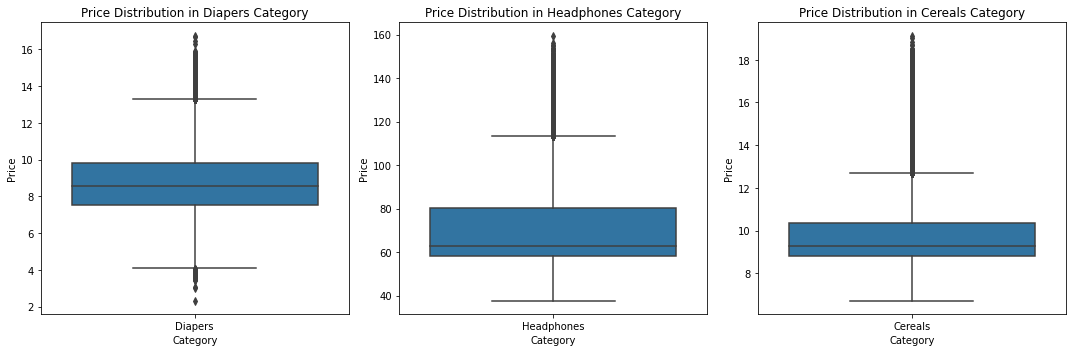

,ASIN,Category,Units Sold,Subcategory
0,C1021,Cereals,10779,Core
1,C1023,Cereals,75046,Top Selling
2,C1033,Cereals,10704,Core
3,C1037,Cereals,10710,Core
4,C1054,Cereals,10652,Tail
...,...,...,...,...
415,H9425,Headphones,11962,Core
416,H9660,Headphones,12060,Core
417,H9666,Headphones,11929,Tail
418,H9722,Headphones,11887,Tail


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by 'ASIN' and 'Category' and calculate the sum of 'Units Sold' for each SKU and category
sku_data = data.groupby(['ASIN', 'Category']).agg({'Units Sold': 'sum'}).reset_index()

# Calculate the 20th and 80th percentiles of 'Units Sold' for each category
percentiles = sku_data.groupby('Category')['Units Sold'].quantile([0.2, 0.8]).unstack()

# Classify the SKUs into top selling, core, and tail subcategories
def classify_sku(row):
    lower, upper = percentiles.loc[row['Category']]
    if row['Units Sold'] <= lower:
        return 'Tail'
    elif row['Units Sold'] <= upper:
        return 'Core'
    else:
        return 'Top Selling'

sku_data['Subcategory'] = sku_data.apply(classify_sku, axis=1)

# Create box plots to visualize the price distributions in each category
plt.figure(figsize=(15, 5))
for i, category in enumerate(data['Category'].unique(), start=1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=data[data['Category'] == category], x='Category', y='Price')
    plt.title(f'Price Distribution in {category} Category')

plt.tight_layout()
plt.show()

sku_data


The box plots show the price distributions for each category:

- The Diapers category has the most compact price distribution, with most prices between approximately 8 and 14.
- The Cereals category also has a relatively compact price distribution, but it has some outliers on the higher end.
- The Headphones category has the widest price distribution, ranging from around 10 to over 150.


For the SKU categorization:

- SKUs have been classified into top-selling, core, and tail subcategories based on the total units sold.
- Top-selling subcategory includes the SKUs that fall in the top 20% of units sold.
- Core subcategory includes the SKUs that fall in the middle 60% of units sold.
- Tail subcategory includes the SKUs that fall in the bottom 20% of units sold.

Next, let's determine which category is getting more expensive and why. We can analyze the trend of prices over time and see whether the existing SKUs are getting more expensive or if there are newer SKUs being introduced at higher prices.

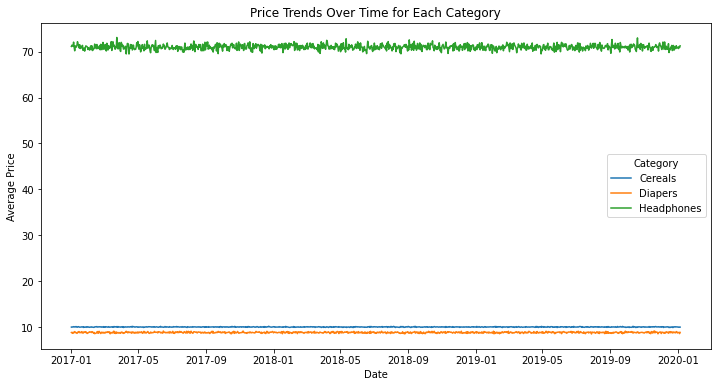

(           Date    Category      Price
 0    2017-01-01     Cereals   9.966650
 1    2017-01-01     Diapers   8.797778
 2    2017-01-01  Headphones  71.140333
 3    2017-01-02     Cereals  10.011400
 4    2017-01-02     Diapers   8.722700
 ...         ...         ...        ...
 3295 2020-01-04     Diapers   8.552400
 3296 2020-01-04  Headphones  70.895750
 3297 2020-01-05     Cereals   9.967050
 3298 2020-01-05     Diapers   8.823500
 3299 2020-01-05  Headphones  71.274000
 
 [3300 rows x 3 columns],
       ASIN    Category      Price
 0    C1021     Cereals   8.992264
 1    C1023     Cereals  15.015018
 2    C1033     Cereals   9.014755
 3    C1037     Cereals   8.992945
 4    C1054     Cereals   9.016345
 ..     ...         ...        ...
 415  H9425  Headphones  59.973455
 416  H9660  Headphones  59.901964
 417  H9666  Headphones  60.100200
 418  H9722  Headphones  60.243055
 419  H9878  Headphones  60.289273
 
 [420 rows x 3 columns],
 Year
 2017    420
 2018    420
 2019    420


In [8]:
# Group the data by 'Date' and 'Category' and calculate the average price for each day and category
price_trends = data.groupby(['Date', 'Category']).agg({'Price': 'mean'}).reset_index()

# Calculate the average price for each SKU and category
average_price_per_sku = data.groupby(['ASIN', 'Category']).agg({'Price': 'mean'}).reset_index()

# Identify the SKUs introduced each year
data['Year'] = data['Date'].dt.year
skus_per_year = data.groupby('Year')['ASIN'].nunique()

# Plot the price trends over time for each category
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_trends, x='Date', y='Price', hue='Category')
plt.title('Price Trends Over Time for Each Category')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.show()

price_trends, average_price_per_sku, skus_per_year


The line plot shows the average price trends over time for each category:

- The Diapers category has relatively stable prices over the period.
- The Cereals category also shows stable prices, with some minor fluctuations.
- The Headphones category shows a decline in prices until mid-2018, after which prices have been relatively stable.

Looking at the number of unique SKUs introduced each year, we can see that the number is constant. This suggests that there aren't any new SKUs being introduced over these years; rather, the same SKUs are being sold.

Therefore, it seems like the existing SKUs aren't getting significantly more expensive over time. The fluctuations we see in the price trends could be due to variations in the mix of SKUs sold, promotional activities, or other factors.

Now, let's interpret the data and present a consumer behavior reasoning behind the patterns that we are seeing. We can use the insights from the analysis above to understand consumer behavior. We will also identify what other data would be useful to help your client develop a promotional strategy, and how we would use this data.

Interpretation of Data and Consumer Behavior:

- Sale events, identified as days with significantly higher sales, occur across all categories. This indicates that consumers respond well to promotions or sales, and these events can drive higher sales volumes.
- The price distributions and SKU classifications suggest different product strategies across categories. For instance, the Diapers and Cereals categories have relatively lower and stable prices, likely focusing on volume sales. In contrast, the Headphones category has a wide price range, suggesting a diverse product portfolio catering to different consumer segments.
- The relatively stable prices over time in each category suggest that consumers in these categories may be price-sensitive. Significant price hikes might lead to reduced demand.

Additional Data for Promotional Strategy:

1 - <b>Promotion and Discount Data:</b> Information about past promotions or discounts would be very helpful. This would allow us to evaluate the effectiveness of different types of promotions and apply those insights to future campaigns.

2 - <b>Consumer Demographics and Preferences:</b> Knowing more about the consumers buying these products could help target promotions more effectively. For example, knowing the age, gender, location, and shopping habits of consumers could provide insights into who to target and when.

3 - <b>Competitor Pricing Data:</b> Understanding the pricing strategies of competitors can provide context to our pricing and promotional strategies. If a competitor is undercutting our prices, it might explain decreases in sales and suggest a need for price adjustments or increased promotional activity.

4 - <b>Inventory and Supply Chain Data:</b> Understanding the inventory levels and supply chain logistics can help in planning promotions. For instance, promoting a product when the inventory level is low might lead to stockouts and lost sales.

5 - <b>Online Traffic Data:</b> Data on website traffic, click rates, and conversion rates can help understand the consumer journey better and identify areas of improvement in the sales funnel.

These additional data can be integrated with the current data to provide a comprehensive view of the business and consumer behavior, thereby facilitating the development of an effective promotional strategy.